## Lexicon Mining for Semiotic Squares: Exploding Binary Classification
## Jason S. Kessler @jasonkessler
## Talk at Data Day Texas, 2018 #ddtx

Refer to the presentation [SemioticSquaresTalk.pptx](https://github.com/JasonKessler/SemioticSquaresTalk/blob/master/SemioticSquaresTalk.pptx) for background on this project, and an in-depth explanation of semiotic squares.

The Github repository for talk is at [https://github.com/JasonKessler/SemioticSquaresTalk](https://github.com/JasonKessler/SemioticSquaresTalk).

Visualizations were made using [Scattertext](https://github.com/JasonKessler/scattertext).

Please cite as: 
Jason S. Kessler. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. ACL System Demonstrations. 2017.


In [1]:
import pandas as pd
import numpy as np
import scattertext as st
import seaborn as sns
from scipy.stats import rankdata
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import matplotlib.pyplot as plt
%matplotlib inline 

### The data
 
Dataset consists of reviews of movies and plot descriptions.  Plot descriptions are guaranteed to be from a movie which was reviewed. 

Data set is from http://www.cs.cornell.edu/people/pabo/movie-review-data/

References:
* Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan, Thumbs up? Sentiment Classification using Machine Learning Techniques, Proceedings of EMNLP 2002.

* Bo Pang and Lillian Lee, A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts, Proceedings of ACL 2004.

In [2]:
rdf = st.SampleCorpora.RottenTomatoes.get_data()
rdf['category_name'] = rdf['category'].apply(lambda x: {'plot': 'Plot', 'rotten': 'Negative', 'fresh': 'Positive'}[x])
print(rdf.category_name.value_counts())
rdf[['text', 'movie_name', 'category_name']].head()

Positive    2455
Negative    2411
Plot         156
Name: category_name, dtype: int64


,text,movie_name,category_name
0,"A senior at an elite college (Katie Holmes), a...",abandon,Plot
1,Will Lightman is a hip Londoner who one day re...,about_a_boy,Plot
2,Warren Schmidt (Nicholson) is forced to deal w...,about_schmidt,Plot
3,An account of screenwriter Charlie Kaufman's (...,adaptation,Plot
4,Ali G unwittingly becomes a pawn in the evil C...,ali_g_indahouse,Plot


In [3]:
corpus = (st.CorpusFromPandas(rdf, 
                              category_col='category_name', 
                              text_col='text',
                              nlp = st.whitespace_nlp_with_sentences)
          .build())
corpus.get_term_freq_df().to_csv('term_freqs.csv')
unigram_corpus = corpus.get_unigram_corpus()

### Let's visualize the corpus using Scattertext

The x-axis indicates the rank of a word or bigram in the set of positive reviews, and the y-axis negative reviews.

Ranks are determined using "dense" ranking, meaning the most frequent terms, regardless of ties, are given rank 1, the next most frequent terms, regardless of ties, are given rank 2, etc.

It appears that terms more associated with a class are a further distance from the diagonal line between the lower-left and upper-right corners.  Terms are colored according to this distance.  We'll return to this in a bit.

Scattertext selectively labels points in such a way as to prevent labels from overlapping other elements of the graph. Mouse-over points and term labels for a preview, and click for a key-word in context view.

References:
* Jason S. Kessler. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. ACL System Demonstrations. 2017.

In [4]:
html = st.produce_scattertext_explorer(
    corpus,
    category='Positive',
    not_categories=['Negative'],
    sort_by_dist=False,
    metadata=rdf['movie_name'],
    term_scorer=st.RankDifference(),
    transform=st.Scalers.percentile_dense
)
file_name = 'rotten_fresh_stdense.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

### We view can see more terms through breaking ties in ranking alphabetically.
Lower frequency terms are more prominent in this view, and more terms can be labeled.

In [5]:
html = st.produce_scattertext_explorer(
    corpus,
    category='Positive',
    not_categories=['Negative'],
    sort_by_dist=False,
    metadata=rdf['movie_name'],
    term_scorer=st.RankDifference(),
)
file_name = 'rotten_fresh_st.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

# Examining term-category association
We'll roughly follow the explanation given in Monroe et. al (2008), culminating in a version of their Log-Odds-Ratio with an Informed Dirichlet Prior score. 

### Naive approach 1
### Frequency difference (not recommended)
$$\mbox{freqdiff}(\mbox{term}) := \frac{\#(\mbox{term}\in\mbox{category}_a)}{\#(\mbox{category}_a)} - \frac{\#(\mbox{term}\in\mbox{category}_b)}{\#(\mbox{category}_b)}$$
Disporportionately favors very frequent words.

References
* Burt L. Monroe, Michael P. Colaresi, and Kevin M. Quinn. 2008. Fightin’ words: Lexical feature selection and evaluation for identifying the content of political conflict. Political Analysis.


In [6]:
class FrequencyDifference:
    def get_scores(self, a, b): 
        return a/np.sum(a) - b/np.sum(b)
    def get_name(self): 
        return 'Frequency Difference'
    
html = st.produce_fightin_words_explorer(
    corpus,
    category='Positive',
    not_categories=['Negative'],
    term_scorer=FrequencyDifference(),
    metadata = rdf['movie_name'],
    grey_threshold=0,
    #y_axis_values=[-.002,0,.002,.004]
)
file_name = 'rotten_fresh_diff.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

### Naive approach 2
### tf.idf difference (not recommended)
$$ \mbox{Inverse Document Frquency}(\mbox{term}) = \log \frac{\mbox{# of categories}}{\mbox{# of categories containing term}} $$

$$ \mbox{Term Frquency}(\mbox{term}, \mbox{category}) = \#(\mbox{term}\in\mbox{category}) $$

$$ \mbox{tf.idf}(\mbox{term}, \mbox{category}) = \mbox{Term Frquency}(\mbox{term}, \mbox{category}) \times \mbox{Inverse Document Frquency}(\mbox{term}) $$

$$ \mbox{tf.idf-difference}(\mbox{term}, \mbox{category}) = \mbox{tf.idf}(\mbox{term}, \mbox{category}_a) - \mbox{tf.idf}(\mbox{term}, \mbox{category}_b) $$

Tf.idf ignores terms used in each category.  Since we only consider three categories (positive, negative and plot descriptions), a large number of terms have zero (log 1) scores.  The problem is Tf.idf doesn't weight how often a term is used in another category.  This causes eccentric, brittle, low-frequency terms to be favored.

This formulation does take into account data from a background corpus.

In [7]:
class TFIDF:
    def __init__(self, corpus):
        self.tdf = corpus.get_term_freq_df()
    def get_scores(self, a, b): 
        n_docs = self.tdf.shape[1]
        n_docs_with_term = (self.tdf > 0).astype(float).sum(axis=1)
        idf = np.log(n_docs/n_docs_with_term)/np.log(2)
        return a * idf - b * idf
    def get_name(self): 
        return 'tf.idf difference'
    
html = st.produce_fightin_words_explorer(
    corpus,
    category='Positive',
    not_categories=['Negative'],
    term_scorer=TFIDF(corpus),
    metadata = rdf['movie_name'],
    grey_threshold=0
)
file_name = 'rotten_fresh_tfidf.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

/Users/kesslej/anaconda3/lib/python3.5/site-packages/scattertext-0.0.2.17-py3.5.egg/scattertext/TermDocMatrixFilter.py:43: RuntimeWarning: invalid value encountered in log
  bigram_prob[bigram] / np.product([unigram_prob[word] for word in bigram.split(' ')])


### Naive approach 3
### Log-odds-ratio w/ smoothing (not recommended)

$$ \newcommand\ddfrac[2]{\frac{\displaystyle #1}{\displaystyle #2}}$$
$$ \mbox{Odds}(\mbox{term}_i, \mbox{category}) = \frac{\#(\mbox{term}_i\in\mbox{category}_a)}{\sum_{\mbox{term}` \neq \mbox{term}} \#(\mbox{term}'\in\mbox{category})} = \frac{y_{ai}}{n_{a} - y_{ai}} $$
Note: this can be a very small number.

The odds ratio is the ratio of the odds of a term being used in one category vs. another.
$$ \mbox{Odds-Ratio}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) =  \ddfrac{y_{ai}\mathbin{/}(n_{a} - y_{ai})}{y_{bi}\mathbin{/}(n_{b} - y_{bi})} $$

Given the likelihood these quantities are very small, the Log-Odds-Ratio is often used.

$$ \mbox{Log-Odds-Ratio}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \log \frac{y_{ai}}{n_{a} - y_{ai}} - \log \frac{y_{bi}}{n_{b} - y_{bi}} $$

If term does not appear in \mbox{category}_b (i.e., $ y_{bi} = 0 $), the odd of term_i in category_b will be 0 resulting the odds-ratio to be undefined.  We circumvent this issue by adding a pseudo-count to each term, assuming it occurs at least $\alpha$ times.  

$$ \mbox{Smoothed Log-Odds-Ratio}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \log \frac{y_{ai} + \alpha}{n_{a} + \alpha \cdot |y| - y_{ai} - \alpha} - \log \frac{y_{bi} + \alpha}{n_{b} + \alpha \cdot |y| - y_{bi} - \alpha} $$

This has a slightly better profile than tf.idf, but still favors very low-frequency terms that are unique to a category.

We can see that terms used exclusively in one category or another clump form extremely high or low-scoring clumps.  These terms occur infrequently.  Intuitively, we'd like to score things highly if they have a lot of evidence behind them AND they tend to be used much more in one category vs. another.

In [8]:
class LogOddsRatioSmoothed:
    def __init__(self, alpha):
        self.alpha = alpha
    def get_scores(self, a, b): 
        return (np.log((a + self.alpha)/(np.sum(a) + self.alpha * len(a) - a - self.alpha)) 
                - np.log((b + self.alpha)/(np.sum(b) + self.alpha * len(b) - b - self.alpha)))
    def get_name(self): 
        return 'Smoothed Log-Odds-Ratio'
    
html = st.produce_fightin_words_explorer(
    corpus,
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    term_scorer=LogOddsRatioSmoothed(0.00000001),
    metadata = rdf['movie_name'],
    grey_threshold=0,
    y_axis_values=[-20, -10, 0, 10, 20]
)
file_name = 'rotten_fresh_lorsmooth.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

### Accounting for variance
How can we account for the certainty of the estimates?  Less frequent terms will have higher variances.

The standard error of the log-odds-ratio is:

$$ \mbox{SE-Smoothed Log-Odds-Ratio}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \frac{1}{y_{ai} + \alpha} + \frac{1}{n_{a} + \alpha \cdot |y| - y_{ai} - \alpha} + \frac{1}{y_{bi} + \alpha}+ \frac{1}{n_{b} + \alpha \cdot |y| - y_{bi} - \alpha} $$

The plot below shows how terms used infrequently and especially those which only appear in one class have a very high variance.

In [9]:
class SELogOddsRatioSmoothed:
    def __init__(self, alpha):
        self.alpha = alpha
    def get_scores(self, a, b): 
        a += self.alpha
        b += self.alpha
        return  1./a + 1./(np.sum(a) - a) + 1./b + 1./(np.sum(b) - b)
    def get_name(self): 
        return 'SE Smoothed Log-Odds-Ratio'
    
html = st.produce_fightin_words_explorer(
    corpus,
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    term_scorer=SELogOddsRatioSmoothed(0.00000001),
    metadata = rdf['movie_name'],
    grey_threshold=0
)
file_name = 'rotten_fresh_lorsmoothse.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

### Smoothed Log-Odds-Prior Z-Score
### Preferred in certain cases

Finding the Z-Scores of log-odds-ratios allows us to gracefully account for variance.

$$ \mbox{LOR Smoothed Z-Score}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \frac{\mbox{LOR Smoothed}}{\sqrt{\mbox{SE LOR Smoothed}}} $$

The chart below, given a smoothing $\alpha$ of 0.01, dampens the score of infrequent words and allows for frequently words to rank highly.  However, the words "and" and "of" appear to be over-weighted. 

Eccentric words like "winning" are down-weighted but still significant.

In [10]:
class LogOddsRatioSmoothedZScorePrior:
    def __init__(self, prior):
        self.prior = prior
    def get_scores(self, a, b): 
        a += self.prior
        b += self.prior
        lor = (np.log(a/(np.sum(a) - a)) - np.log(b/(np.sum(b) - b)))
        lorstd = 1./a + 1./(np.sum(a) - a) + 1./b + 1./(np.sum(b) - b)
        return lor/np.sqrt(lorstd)
        
    def get_name(self): 
        return 'Smoothed Log-Odds-Ratio w/ Prior Z-Score'
html = st.produce_fightin_words_explorer(
    corpus,
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    term_scorer=LogOddsRatioSmoothedZScorePrior(0.01),
    metadata = rdf['movie_name'],
    grey_threshold = 1.96
)
file_name = 'rotten_fresh_loridp.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

### Log-Odds-Ratio with Informative Dirichlet Prior Z-Score
### Prefered, currently very popular in NLP and CSS literature, flaws exist
### Note: this formulation is modified slightly from Monroe et al. 2008.

We know, intuitively, words which which are used very frequently require much more evidence to be significantly associated with a class than less frequent words.  For example, words like "best" and "entertaining" in the above example should be scored lower than "and" and "of".  

The approach developed by Monroe et. al is to more aggressively smooth terms based on their frequency in a background corpus.

The downside is of this approach is that obtaining a background corpus may be difficult. Lists of background term frequencies, especially for 2+grams, can be very large and unwieldy. Moreover, term frequency lists can become outdated very quickly, especially wrt to politics, pop culture, and technology.

We construct two vectors of background term counts for each category, $\alpha_a$ and $\alpha_b$.  The priors are based on a background set of word frequencies, referred to as $y_{c}$  These are ideally in the same domain as the documents being studied, although could come from a general list of word frequencies.  The background counts are normalized to the size of their respective categories. The hyperparameter $\sigma$ scales the background counts to a multiple of their category size. In other words, as $\sigma$ increases, the regularization increases, and the odds ratio tends more toward zero.

The $\sigma$ I've found most useful is 10, which I include in Scattertext.

$$ \alpha_a = \sigma \cdot n_a \cdot \frac{y_{ci}}{n_c} $$

$$ \alpha_b = \sigma \cdot n_b \cdot \frac{y_{ci}}{n_c} $$

The $\alpha$s can then be used analogously to find the Z-Score of the LOR.

$$ \mbox{LOR}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \log \frac{y_{ai} + \alpha_a}{n_{a} + \alpha_a \cdot |y| - y_{ai} - \alpha_a} - \log \frac{y_{bi} + \alpha_b}{n_{b} + \alpha_b \cdot |y| - y_{bi} - \alpha_b} $$

$$ \mbox{LOR-SE}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \frac{1}{y_{ai} + \alpha_a} + \frac{1}{n_{a} + \alpha_a \cdot |y| - y_{ai} - \alpha_a} + \frac{1}{y_{bi} + \alpha_b}+ \frac{1}{n_{b} + \alpha_b \cdot |y| - y_{bi} - \alpha_b} $$

In the following example, we use the plot description as a background corpus.

In [11]:
priors = (st.PriorFactory(unigram_corpus, 
                          category='Positive', 
                          not_categories=['Negative'],
                          starting_count=0.01)
          .use_neutral_categories()
          .get_priors())
class LogOddsRatioSmoothedZScorePrior:
    def __init__(self, prior, prior_scale):
        self.prior = prior
        self.prior_scale = prior_scale
    def get_scores(self, a, b): 
        ap = a + self.prior * self.prior_scale*sum(a)/sum(self.prior.values)
        bp = b + self.prior * self.prior_scale*sum(b)/sum(self.prior.values)
        lor = (np.log(ap/(np.sum(ap) - ap)) - np.log(bp/(np.sum(bp) - bp)))
        lorstd = 1./ap + 1./(np.sum(ap) - ap) + 1./bp + 1./(np.sum(bp) - bp)
        return lor/np.sqrt(lorstd)
        
    def get_name(self): 
        return 'Log-Odds-Ratio w/ Informative Prior Z-Score'
html = st.produce_fightin_words_explorer(
    unigram_corpus,
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    term_scorer=LogOddsRatioSmoothedZScorePrior(priors, 10),
    # Equivalent of 
    # term_scorer=st.LogOddsRatioInformativeDirichletPrior(priors, 10),    
    metadata = rdf['movie_name']
)
file_name = 'rotten_fresh_loridp.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

### Effect of $\sigma$
In the plot below, we can see how a changing $\sigma$ alters the z-scores of low and high-frequency terms which are associated the Positive category.

A high $\sigma$ causes the infrequent word "winning", which only occurs in Positive documents, to dominate more frequent, associated terms.  A very low $\sigma$ causes rankings to revert to Smoothed LOR Z-Score.

Text(0,0.5,'Z-Score')

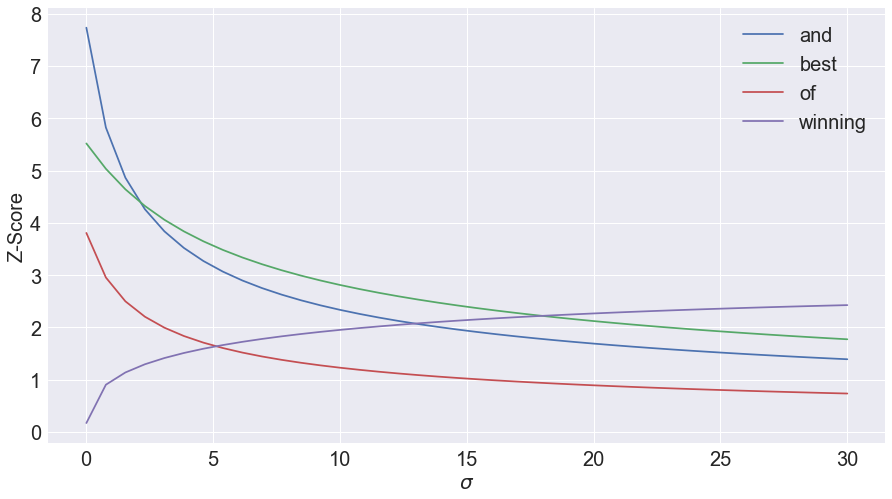

In [12]:
term_freqs = unigram_corpus.get_term_freq_df()
data = []
for sigma in np.linspace(0.01, 30, 40):
    scores = LogOddsRatioSmoothedZScorePrior(priors, sigma).get_scores(term_freqs['Positive freq'], term_freqs['Negative freq'])
    for term in ['and', 'best', 'winning', 'of']:
        data.append({'term': term, 'score': scores[term], 'sigma': sigma})
ax = (pd.DataFrame(data)
 .pivot(index='sigma', columns='term', values='score')
 .plot(figsize=(15, 8), fontsize=20))
ax.legend(prop={'size': 20})
ax.set_xlabel('$\sigma$', size= 20)
ax.set_ylabel('Z-Score', size= 20)

### Dense rank differences
### Prefered, but may under-score extremely frequent and infrequent terms

Let $\rho_\mbox{category}$ be the dense rank function for a given category.

Let $d_\mbox{category}$ be the number of distinct term frequencies in a category

This metric takes the difference of the normalized category-specific dense ranks of term frequencies. 

Define the rank-difference score as the difference in 
$$\mbox{Rank-Difference} = \frac{\rho_{a}(y_a)}{d_a} - \frac{\rho_{b}(y_b)}{d_b}$$

We can see that the words which occur fairly frequently are favored.  Frequent and very infrequent words are heavily regularized.

No background frequencies are required!

In [13]:
class RankDifference:
    def get_scores(self, a, b): 
        return rankdata(a,'dense')/np.max(rankdata(a,'dense')) - rankdata(b,'dense')/np.max(rankdata(b,'dense'))
    def get_name(self): 
        return 'Rank Difference'
    
html = st.produce_fightin_words_explorer(
    corpus,
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    term_scorer=RankDifference(),
    metadata = rdf['movie_name'],
    grey_threshold=0
)
file_name = 'rotten_fresh_rankdiff.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

In [14]:
rdf['domain'] = rdf.category_name.apply(lambda x: 'Plot' if x == 'Plot' else 'Review')
plotcorpus = (st.CorpusFromPandas(rdf, 
                              category_col='domain', 
                              text_col='text',
                              nlp = st.whitespace_nlp_with_sentences)
          .build())
html = st.produce_fightin_words_explorer(
    plotcorpus,
    category='Review',
    not_category_name='Plot',
    term_scorer=RankDifference(),
    metadata = rdf['movie_name'],
    grey_threshold=0
)
file_name = 'plot_rankdiff.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

In [15]:
phrase_corpus = (st.CorpusFromPandas(rdf, 
                                     category_col='category_name', 
                                     text_col='text',
                                     nlp = st.whitespace_nlp_with_sentences, 
                                     feats_from_spacy_doc = st.PhraseMachinePhrases())
          .build())

In [16]:
tdf = phrase_corpus.get_term_freq_df()

In [17]:
priors = (st.PriorFactory(phrase_corpus, 
                          category='Positive', 
                          not_categories=['Negative'],
                          starting_count=0.01)
          .use_neutral_categories()
          .get_priors())

### And the semiotic square using SE-LOR/Background

In [18]:
semiotic_square = st.SemioticSquare(
    phrase_corpus,
    category_a='Positive',
    category_b='Negative',
    neutral_categories=['Plot'],
    scorer=st.LogOddsRatioInformativeDirichletPrior(priors, 10),
)

html = st.produce_semiotic_square_explorer(semiotic_square,
                                           category_name='Positive',
                                           not_category_name='Negative',
                                           x_label='Positive-Negative',
                                           y_label='Review-Plot',
                                           neutral_category_name='Plot Description',
                                           metadata=rdf['movie_name'])

fn = 'semiotic_square_loridp.html'
open(fn, 'wb').write(html.encode('utf-8'))
IFrame(src=fn, width = 1600, height=900)

### The Semiotic Square using RankDiff

In [20]:
semiotic_square = st.SemioticSquare(
    phrase_corpus,
    category_a='Positive',
    category_b='Negative',
    neutral_categories=['Plot'],
    scorer=st.RankDifference(),
)

html = st.produce_semiotic_square_explorer(semiotic_square,
                                           category_name='Positive',
                                           not_category_name='Negative',
                                           x_label='Positive-Negative',
                                           y_label='Review-Plot',
                                           neutral_category_name='Plot Description',
                                           metadata=rdf['movie_name'])

fn = 'semiotic_square_rankdiff.html'
open(fn, 'wb').write(html.encode('utf-8'))
IFrame(src=fn, width = 1600, height=900)